In [1]:
import cyecca.lie as lie
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derive():
    x0 = ca.SX.sym("x", 4)
    w = ca.SX.sym("w", 3)

    X = lie.SO3Mrp.element(x0)

    # gyro prediction
    W = lie.so3.element(w)
    dt = ca.SX.sym("dt")

    # this is a geodetic (assuming contant gyro), so euler prediction is exact
    # this is equivalent to:
    # X = X*(W*dt).exp(lie.SO3Mrp)
    X += W * dt

    # shadow Mrp if necessary
    x1 = lie.SO3Mrp.shadow_param_if_necessary(X.param)

    f_predict = ca.Function("predict", [w, x0, dt], [x1], ["w", "x0", "dt"], ["x1"])

    return {"f_predict": f_predict}


eqs = derive()

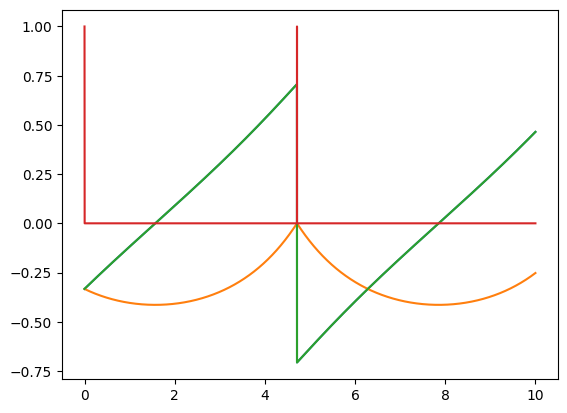

In [3]:
def simulate(t0=0, tf=10, dt=0.001):
    t = t0
    x = np.array([1, 1, 1, 0])
    omega = np.array([1, 0, 0])
    hist = {
        "x": [],
        "t": [],
    }

    t_vect = np.arange(start=t0, stop=tf, step=dt)

    for t in t_vect:
        x = eqs["f_predict"](omega, x, dt)
        hist["x"].append(np.array(x).reshape(-1))
        hist["t"].append(t)
        t += dt

    for k in hist.keys():
        hist[k] = np.array(hist[k])

    plt.plot(hist["t"], hist["x"])


simulate()

In [4]:
lie.SO3Mrp.shadow_param(ca.SX([0.1, 0, 0, 0]))

SX(@1=0, [-10, @1, @1, 1])

In [5]:
q = lie.SO3Quat.element(ca.SX([1, 0, 0, 0]))
dcm = lie.SO3Dcm.element(ca.SX.eye(3).reshape((9, 1)))
mrp = lie.SO3Mrp.from_SO3Quat(q)

In [6]:
dcm

SO3DcmLieGroup: SX(@1=1, [@1, 00, 00, 00, @1, 00, 00, 00, @1])

In [7]:
lie.SO3Dcm.from_matrix(ca.SX.eye(3))

SO3DcmLieGroup: SX(@1=1, [@1, 00, 00, 00, @1, 00, 00, 00, @1])

In [8]:
lie.SO3Dcm.from_SO3Quat(q).to_Matrix()

SX(@1=1, @2=0, 
[[@1, @2, @2], 
 [@2, @1, @2], 
 [@2, @2, @1]])

In [9]:
R = lie.SO3Dcm.from_SO3Quat(q)

In [10]:
R.to_Matrix()

SX(@1=1, @2=0, 
[[@1, @2, @2], 
 [@2, @1, @2], 
 [@2, @2, @1]])